Attempting to load dataset from: IMDB Dataset.csv
Dataset loaded successfully with shape: (50000, 2)
Converting sentiment to numeric rating...

Dataset sample:
                                              review sentiment  rating
0  One of the other reviewers has mentioned that ...  positive       5
1  A wonderful little production. <br /><br />The...  positive       5
2  I thought this was a wonderful way to spend ti...  positive       5
3  Basically there's a family where a little boy ...  negative       1
4  Petter Mattei's "Love in the Time of Money" is...  positive       5
Dataset shape: (50000, 3)

Rating distribution:
stars
1    25000
5    25000
Name: count, dtype: int64

Preprocessing reviews...
Processing batch 1/51
Processing batch 2/51
Processing batch 3/51
Processing batch 4/51
Processing batch 5/51
Processing batch 6/51
Processing batch 7/51
Processing batch 8/51
Processing batch 9/51
Processing batch 10/51
Processing batch 11/51
Processing batch 12/51
Processing batch 13

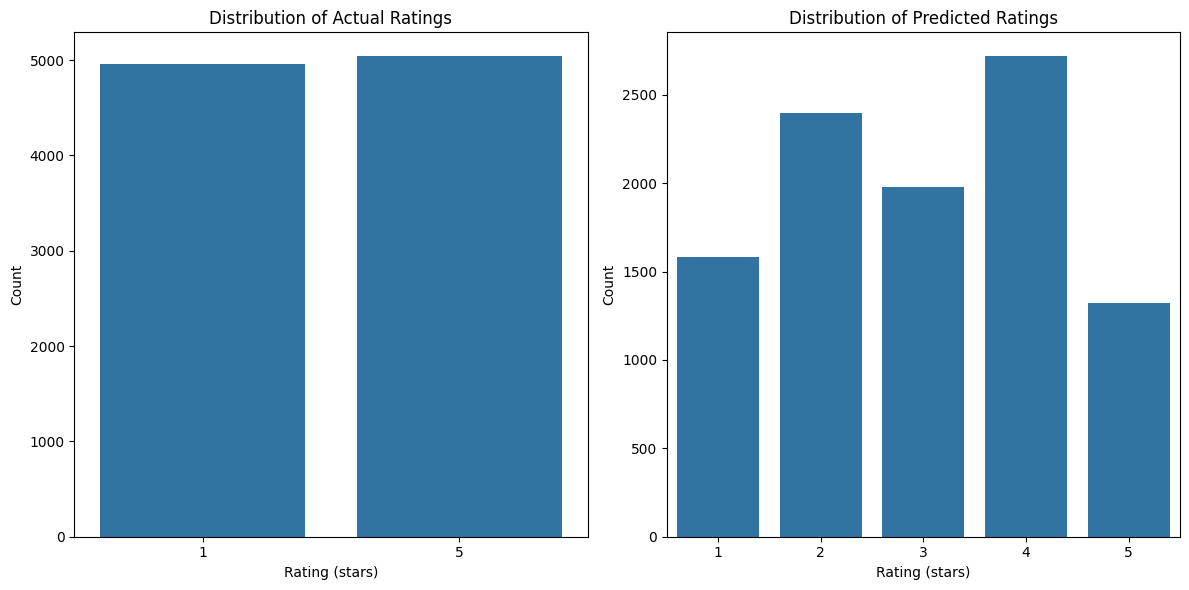

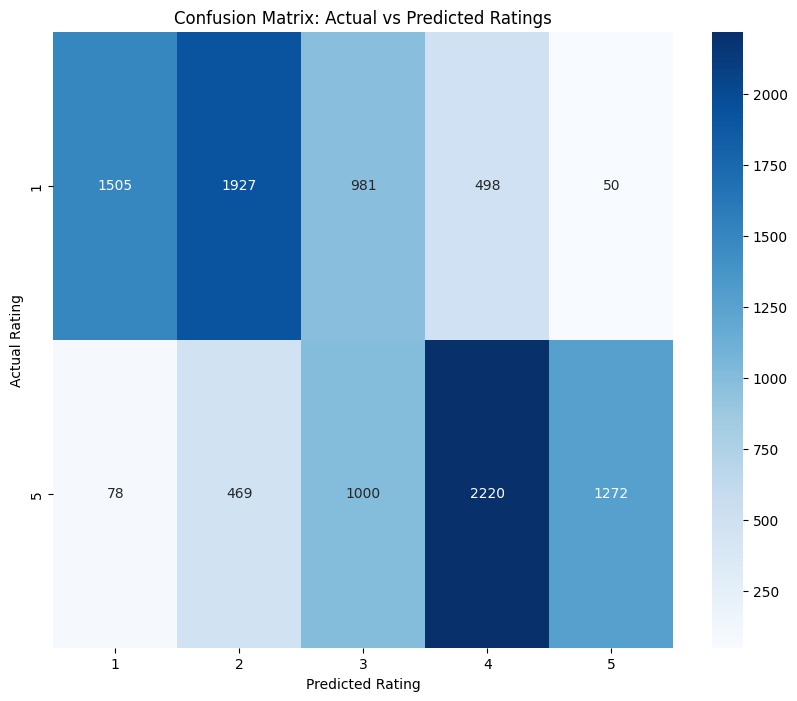


Full results saved to 'imdb_sentiment_analysis_results.csv'

Creating comprehensive output dataset...
Processing explanations batch 1/11
Processing explanations batch 2/11
Processing explanations batch 3/11
Processing explanations batch 4/11
Processing explanations batch 5/11
Processing explanations batch 6/11
Processing explanations batch 7/11
Processing explanations batch 8/11
Processing explanations batch 9/11
Processing explanations batch 10/11
Comprehensive results saved to 'imdb_sentiment_comprehensive_results.csv'

Example Predictions for New Reviews:

Review: I absolutely loved this movie! The acting was superb and the plot kept me engaged throughout.
Predicted Rating: 3 stars
Sentiment: Neutral
Explanation: No specific explanation found

Review: This film was just okay. Nothing special but not terrible either.
Predicted Rating: 1 stars
Sentiment: Extremely negative
Explanation: Nothing special but not terrible either; This film was just okay

Review: One of the worst movies I

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import os

# Download necessary NLTK resources with more specific packages
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)  # Open Multilingual WordNet

# Load IMDB dataset from Kaggle
def load_kaggle_imdb_data(file_path='IMDB Dataset.csv'):
    try:
        print(f"Attempting to load dataset from: {file_path}")
        # Check if file exists
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File {file_path} not found")

        # Load the dataset
        data = pd.read_csv(file_path)
        print(f"Dataset loaded successfully with shape: {data.shape}")

        # Rename columns for consistency with our code
        if 'review' not in data.columns:
            # Look for column that might contain review text
            text_columns = [col for col in data.columns if data[col].dtype == object]
            if text_columns:
                data = data.rename(columns={text_columns[0]: 'review'})

        # Check sentiment column
        if 'sentiment' in data.columns:
            # Convert sentiment to numeric rating
            print("Converting sentiment to numeric rating...")
            # Map positive/negative to rating (5 for positive, 1 for negative)
            sentiment_mapping = {'positive': 5, 'negative': 1}
            data['rating'] = data['sentiment'].map(sentiment_mapping)

            # For intermediate sentiments, if they exist
            if not all(data['sentiment'].isin(['positive', 'negative'])):
                # Handle other sentiments if present
                print("Found complex sentiment data, mapping to 1-5 scale...")
                sentiment_scale = {
                    'negative': 1,
                    'somewhat negative': 2,
                    'neutral': 3,
                    'somewhat positive': 4,
                    'positive': 5
                }
                data['rating'] = data['sentiment'].map(lambda x: sentiment_scale.get(x.lower(), 3))
        else:
            # If no sentiment column, check if there's a rating column
            rating_columns = [col for col in data.columns if 'rat' in col.lower()]
            if rating_columns:
                data = data.rename(columns={rating_columns[0]: 'rating'})
            else:
                print("No sentiment or rating column found. Using dummy ratings.")
                data['rating'] = 3  # Default neutral rating

        return data
    except Exception as e:
        print(f"Error loading dataset: {e}")
        print("Creating a sample dataset instead...")
        # Create sample dataset for demonstration
        reviews = [
            "This movie was absolutely fantastic! The acting, direction, and screenplay were perfect.",
            "One of the best films I've seen this year. Incredible performances.",
            "Pretty good movie, but it had some pacing issues. Overall enjoyable.",
            "It was okay. Some good moments but not particularly memorable.",
            "This movie was a disappointment. The plot made no sense and the acting was stiff.",
            "Terrible film. Complete waste of time and money. Avoid at all costs.",
            "Mixed feelings about this one. Great cinematography but weak story.",
            "Exceptional performances by the entire cast. Highly recommended!",
            "Boring and predictable. I nearly fell asleep halfway through.",
            "This film exceeded all my expectations. A true masterpiece."
        ]

        # Assign ratings and sentiments
        sentiments = ['positive', 'positive', 'positive', 'neutral', 'negative',
                      'negative', 'neutral', 'positive', 'negative', 'positive']
        ratings = [5, 5, 4, 3, 2, 1, 3, 5, 1, 5]

        data = pd.DataFrame({
            'review': reviews,
            'sentiment': sentiments,
            'rating': ratings
        })

        return data

# Try to load the dataset
data = load_kaggle_imdb_data()

# Display sample of the dataset
print("\nDataset sample:")
print(data.head())
print(f"Dataset shape: {data.shape}")

# Convert the ratings to a 5-star scale if they're on a different scale
if data['rating'].max() > 5:
    data['stars'] = (data['rating'] * 5 / data['rating'].max()).round()
else:
    data['stars'] = data['rating']

print("\nRating distribution:")
print(data['stars'].value_counts().sort_index())

# Text preprocessing function
def preprocess_text(text):
    # Check if the text is a string
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Split on whitespace
    tokens = text.split()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back to text
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

# Apply preprocessing to reviews (with progress tracking for large datasets)
print("\nPreprocessing reviews...")
# For large datasets, apply in batches or use tqdm for progress tracking
if len(data) > 10000:
    batch_size = 1000
    processed_reviews = []
    for i in range(0, len(data), batch_size):
        print(f"Processing batch {i//batch_size + 1}/{(len(data)//batch_size) + 1}")
        batch = data['review'].iloc[i:i+batch_size].apply(preprocess_text)
        processed_reviews.extend(batch)
    data['processed_review'] = processed_reviews
else:
    data['processed_review'] = data['review'].apply(preprocess_text)

print("Preprocessing complete.")

# Split the data
X = data['processed_review']
y = data['stars']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
print("\nVectorizing text data...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train a regression model to predict star rating
print("\nTraining Random Forest model...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_tfidf)
y_pred_rounded = np.round(y_pred)

print(f"\nModel Evaluation:")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

# Function to map rating to sentiment explanation
def get_sentiment_explanation(rating):
    if rating <= 1:
        return "Extremely negative"
    elif rating <= 2:
        return "Very negative"
    elif rating < 3:
        return "Negative"
    elif rating == 3:
        return "Neutral"
    elif rating < 4:
        return "Somewhat positive"
    elif rating <= 4.5:
        return "Positive"
    else:
        return "Very positive"

# Create a simple rule-based sentiment analyzer
def simple_sentiment_analysis(text):
    positive_words = ['good', 'great', 'excellent', 'amazing', 'fantastic', 'wonderful', 'perfect',
                      'best', 'love', 'loved', 'enjoyed', 'favorite', 'recommend', 'incredible', 'brilliant',
                      'superb', 'outstanding', 'awesome', 'masterpiece', 'beautiful', 'impressive',
                      'entertaining', 'fun', 'interesting', 'compelling', 'moving', 'powerful', 'touching']

    negative_words = ['bad', 'poor', 'terrible', 'awful', 'boring', 'worst', 'hate', 'disappointing',
                      'waste', 'dull', 'mediocre', 'horrible', 'stupid', 'failed', 'rubbish', 'ridiculous',
                      'mess', 'pathetic', 'painful', 'avoid', 'disliked', 'terrible', 'worst', 'annoying',
                      'terrible', 'confused', 'hollow', 'predictable', 'slow', 'pointless', 'badly']

    text_lower = text.lower()
    words = re.findall(r'\b\w+\b', text_lower)

    pos_count = sum(1 for word in words if word in positive_words)
    neg_count = sum(1 for word in words if word in negative_words)

    if pos_count > neg_count:
        return 'POSITIVE', (pos_count / (pos_count + neg_count + 0.1))
    else:
        return 'NEGATIVE', (neg_count / (pos_count + neg_count + 0.1))

# Function to extract key phrases explaining the sentiment
def extract_key_phrases(review, predicted_rating):
    # Get sentiment polarity
    sentiment = "positive" if predicted_rating > 3 else "negative"

    # Break review into sentences - simple split on period, question and exclamation marks
    sentences = re.split(r'[.!?]+', review)
    sentences = [s.strip() for s in sentences if len(s.strip()) > 0]

    # Analyze each sentence for sentiment
    results = []
    for sentence in sentences:
        if len(sentence.split()) > 3:  # Ensure the sentence has substance
            label, score = simple_sentiment_analysis(sentence)
            # Check if sentiment matches the overall review sentiment
            if (label == 'POSITIVE' and sentiment == 'positive') or \
               (label == 'NEGATIVE' and sentiment == 'negative'):
                results.append((sentence, score))

    # Sort by confidence and return top 2 explanatory phrases
    if results:
        results.sort(key=lambda x: x[1], reverse=True)
        return results[:2]
    else:
        return [("No specific explanation found", 0.0)]

# Create a new dataframe with predictions
print("\nGenerating predictions and explanations...")
results_df = pd.DataFrame({
    'review': data['review'].iloc[X_test.index].reset_index(drop=True),
    'actual_rating': y_test.reset_index(drop=True),
    'predicted_rating': y_pred_rounded.astype(int),
    'sentiment_category': [get_sentiment_explanation(rating) for rating in y_pred_rounded]
})

# Add explanation for a sample of the results
sample_size = min(20, len(results_df))
sample_indices = np.random.choice(len(results_df), sample_size, replace=False)
sample_results = results_df.iloc[sample_indices].copy()

# Extract key phrases for explanation
explanations = []
for idx, row in sample_results.iterrows():
    key_phrases = extract_key_phrases(row['review'], row['predicted_rating'])
    explanation = "; ".join([phrase for phrase, score in key_phrases])
    explanations.append(explanation)

sample_results['explanation'] = explanations

# Display the results
print("\nSample Results with Explanations:")
print(sample_results[['review', 'actual_rating', 'predicted_rating', 'sentiment_category', 'explanation']])

# Visualize the distribution of actual vs predicted ratings
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='actual_rating', data=results_df)
plt.title('Distribution of Actual Ratings')
plt.xlabel('Rating (stars)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x='predicted_rating', data=results_df)
plt.title('Distribution of Predicted Ratings')
plt.xlabel('Rating (stars)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Confusion matrix heatmap
plt.figure(figsize=(10, 8))
conf_mat = pd.crosstab(results_df['actual_rating'], results_df['predicted_rating'])
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Actual vs Predicted Ratings')
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating')
plt.show()

# Save the results to a CSV file
output_file = 'imdb_sentiment_analysis_results.csv'
results_df.to_csv(output_file, index=False)
print(f"\nFull results saved to '{output_file}'")

# Create a more comprehensive output dataset
print("\nCreating comprehensive output dataset...")
# Process all reviews for explanations
all_explanations = []
batch_size = 1000
for i in range(0, len(results_df), batch_size):
    print(f"Processing explanations batch {i//batch_size + 1}/{(len(results_df)//batch_size) + 1}")
    batch = results_df.iloc[i:i+batch_size]
    for idx, row in batch.iterrows():
        key_phrases = extract_key_phrases(row['review'], row['predicted_rating'])
        explanation = "; ".join([phrase for phrase, score in key_phrases])
        all_explanations.append(explanation)

results_df['explanation'] = all_explanations

# Save the comprehensive results
comprehensive_output = 'imdb_sentiment_comprehensive_results.csv'
results_df.to_csv(comprehensive_output, index=False)
print(f"Comprehensive results saved to '{comprehensive_output}'")

# Function to predict rating for a new review
def predict_rating_with_explanation(review_text):
    # Preprocess the text
    processed_text = preprocess_text(review_text)

    # Vectorize
    review_tfidf = tfidf_vectorizer.transform([processed_text])

    # Predict rating
    pred_rating = rf_model.predict(review_tfidf)[0]
    rounded_rating = round(pred_rating)

    # Get sentiment category
    sentiment_category = get_sentiment_explanation(rounded_rating)

    # Get explanation
    key_phrases = extract_key_phrases(review_text, rounded_rating)
    explanation = "; ".join([phrase for phrase, score in key_phrases])

    return {
        'review': review_text,
        'predicted_rating': rounded_rating,
        'sentiment_category': sentiment_category,
        'explanation': explanation
    }

# Example usage of the prediction function
print("\nExample Predictions for New Reviews:")
example_reviews = [
    "I absolutely loved this movie! The acting was superb and the plot kept me engaged throughout.",
    "This film was just okay. Nothing special but not terrible either.",
    "One of the worst movies I've ever seen. Poor acting, confusing plot, and terrible effects."
]

for review in example_reviews:
    result = predict_rating_with_explanation(review)
    print(f"\nReview: {result['review']}")
    print(f"Predicted Rating: {result['predicted_rating']} stars")
    print(f"Sentiment: {result['sentiment_category']}")
    print(f"Explanation: {result['explanation']}")

print("\nCode execution complete! You now have:")
print("1. A trained sentiment analysis model")
print("2. A comprehensive dataset with original reviews, predicted ratings, and explanations")
print("3. A function to analyze new reviews")
print("4. Visualizations of the model performance")

In [ ]:
!pip install --upgrade transformers sympy numpy torch tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 199.2/211.5 MB 2.4 MB/s eta 0:00:06
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

# Load dataset
df = pd.read_csv("IMDB Dataset.csv")
df.dropna(inplace=True)

# Encode sentiment labels
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=42)

# TF-IDF Feature Extraction
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(train_texts).toarray()
X_test_tfidf = tfidf.transform(test_texts).toarray()

# BERT Feature Extraction
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(texts):
    embeddings = []
    for text in tqdm(texts):
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        embeddings.append(outputs.last_hidden_state[:, 0, :].numpy().flatten())
    return np.array(embeddings)

X_train_bert = get_bert_embeddings(train_texts)
X_test_bert = get_bert_embeddings(test_texts)

# LSTM Autoencoder for Feature Extraction
def create_autoencoder(input_dim):
    model = Sequential([
        LSTM(128, activation='relu', input_shape=(input_dim, 1), return_sequences=True),
        LSTM(64, activation='relu', return_sequences=False),
        RepeatVector(input_dim),
        LSTM(64, activation='relu', return_sequences=True),
        LSTM(128, activation='relu', return_sequences=True),
        TimeDistributed(Dense(1))
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

max_len = 500
X_train_padded = pad_sequences(X_train_tfidf, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_tfidf, maxlen=max_len, padding='post')

X_train_reshaped = np.expand_dims(X_train_padded, axis=-1)
X_test_reshaped = np.expand_dims(X_test_padded, axis=-1)

autoencoder = create_autoencoder(max_len)
autoencoder.fit(X_train_reshaped, X_train_reshaped, epochs=10, batch_size=32, validation_data=(X_test_reshaped, X_test_reshaped))

encoder = Sequential(autoencoder.layers[:3])
X_train_lstm = encoder.predict(X_train_reshaped)
X_test_lstm = encoder.predict(X_test_reshaped)

# Combine Features
X_train_combined = np.hstack((X_train_tfidf, X_train_bert, X_train_lstm))
X_test_combined = np.hstack((X_test_tfidf, X_test_bert, X_test_lstm))

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_combined, train_labels)

# Evaluate Model
y_pred = clf.predict(X_test_combined)
accuracy = accuracy_score(test_labels, y_pred)
print("Model Accuracy:", accuracy)


KeyboardInterrupt: 

encoders added

In [ ]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertModel, GPT2Tokenizer, GPT2Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load dataset
df = pd.read_csv("IMDB Dataset.csv")
df.dropna(inplace=True)
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=42)

# TF-IDF Feature Extraction
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(train_texts).toarray()
X_test_tfidf = tfidf.transform(test_texts).toarray()

# Load BERT (Encoder) and GPT-2 (Generator Encoder)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = GPT2Model.from_pretrained('gpt2')

# Extract BERT Features
def get_bert_embeddings(texts):
    embeddings = []
    for text in tqdm(texts, desc="Extracting BERT Embeddings"):
        inputs = bert_tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        embeddings.append(outputs.last_hidden_state[:, 0, :].numpy().flatten())
    return np.array(embeddings)

X_train_bert = get_bert_embeddings(train_texts)
X_test_bert = get_bert_embeddings(test_texts)

# Extract GPT-2 Features
def get_gpt2_embeddings(texts):
    embeddings = []
    for text in tqdm(texts, desc="Extracting GPT-2 Embeddings"):
        inputs = gpt2_tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = gpt2_model(**inputs)
        embeddings.append(outputs.last_hidden_state[:, -1, :].numpy().flatten())
    return np.array(embeddings)

X_train_gpt2 = get_gpt2_embeddings(train_texts)
X_test_gpt2 = get_gpt2_embeddings(test_texts)

# LSTM Autoencoder
def create_autoencoder(input_dim):
    model = Sequential([
        LSTM(128, activation='relu', input_shape=(input_dim, 1), return_sequences=True),
        LSTM(64, activation='relu', return_sequences=False),
        RepeatVector(input_dim),
        LSTM(64, activation='relu', return_sequences=True),
        LSTM(128, activation='relu', return_sequences=True),
        TimeDistributed(Dense(1))
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

max_len = 500
X_train_padded = pad_sequences(X_train_tfidf, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_tfidf, maxlen=max_len, padding='post')

X_train_reshaped = np.expand_dims(X_train_padded, axis=-1)
X_test_reshaped = np.expand_dims(X_test_padded, axis=-1)

autoencoder = create_autoencoder(max_len)
autoencoder.fit(X_train_reshaped, X_train_reshaped, epochs=10, batch_size=32, validation_data=(X_test_reshaped, X_test_reshaped))

encoder = Sequential(autoencoder.layers[:3])
X_train_lstm = encoder.predict(X_train_reshaped)
X_test_lstm = encoder.predict(X_test_reshaped)

# Mix Encoder - Dynamically Weighted Features
def mix_features(bert_features, gpt2_features, lstm_features, alpha=0.4, beta=0.3, gamma=0.3):
    return alpha * bert_features + beta * gpt2_features + gamma * lstm_features

# Hyperparameter Tuning for Mix Encoder
def optimize_weights():
    def objective(params):
        alpha, beta, gamma = params
        if alpha + beta + gamma != 1:  # Ensure sum to 1
            return float('inf')

        X_train_mixed = mix_features(X_train_bert, X_train_gpt2, X_train_lstm, alpha, beta, gamma)
        X_test_mixed = mix_features(X_test_bert, X_test_gpt2, X_test_lstm, alpha, beta, gamma)

        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_train_mixed, train_labels)
        y_pred = clf.predict(X_test_mixed)
        return -accuracy_score(test_labels, y_pred)  # Minimize loss

    opt_result = minimize(objective, x0=[0.4, 0.3, 0.3], bounds=[(0,1), (0,1), (0,1)], constraints={'type': 'eq', 'fun': lambda x: sum(x)-1})
    return opt_result.x

# Get optimized weights
best_alpha, best_beta, best_gamma = optimize_weights()
print(f"Optimized Weights: α={best_alpha}, β={best_beta}, γ={best_gamma}")

# Apply Optimized Mix Encoder
X_train_combined = mix_features(X_train_bert, X_train_gpt2, X_train_lstm, best_alpha, best_beta, best_gamma)
X_test_combined = mix_features(X_test_bert, X_test_gpt2, X_test_lstm, best_alpha, best_beta, best_gamma)

# Train Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_combined, train_labels)

# Evaluate Model
y_pred = clf.predict(X_test_combined)
accuracy = accuracy_score(test_labels, y_pred)
print("Final Model Accuracy:", accuracy)

# Inference Function
def predict_sentiment(text):
    """Predict sentiment for a new review using trained model."""

    # Get BERT Features
    inputs = bert_tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        bert_output = bert_model(**inputs).last_hidden_state[:, 0, :].numpy().flatten()

    # Get GPT-2 Features
    inputs = gpt2_tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        gpt2_output = gpt2_model(**inputs).last_hidden_state[:, -1, :].numpy().flatten()

    # Get LSTM Autoencoder Features
    padded_tfidf = pad_sequences(tfidf.transform([text]).toarray(), maxlen=max_len, padding='post')
    lstm_input = np.expand_dims(padded_tfidf, axis=-1)
    lstm_output = encoder.predict(lstm_input).flatten()

    # Mix Features
    mixed_features = mix_features(bert_output, gpt2_output, lstm_output, best_alpha, best_beta, best_gamma)

    # Predict Sentiment
    prediction = clf.predict([mixed_features])[0]
    return "Positive" if prediction == 1 else "Negative"

# Example Usage
review_text = "The movie was an absolute masterpiece, full of emotion and great storytelling."
print(f"Predicted Sentiment: {predict_sentiment(review_text)}")


improved
transformer based

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW
from tqdm import tqdm
import openai

# Load dataset
df = pd.read_csv("IMDB Dataset.csv")
df.dropna(inplace=True)

# Encode sentiment labels
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=42)

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings
def get_bert_embeddings(texts):
    bert_model = BertModel.from_pretrained('bert-base-uncased')
    embeddings = []
    for text in tqdm(texts):
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        embeddings.append(outputs.last_hidden_state[:, 0, :].numpy().flatten())
    return np.array(embeddings)

X_train_bert = get_bert_embeddings(train_texts)
X_test_bert = get_bert_embeddings(test_texts)

# SimCSE Contrastive Learning BERT Model
class SimCSEBERT(nn.Module):
    def __init__(self, model_name="bert-base-uncased"):
        super(SimCSEBERT, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        sentence_embedding = outputs.last_hidden_state[:, 0, :]
        return sentence_embedding

simcse_model = SimCSEBERT()

# Attention-Based Feature Fusion
class AttentionFusion(nn.Module):
    def __init__(self, input_dim):
        super(AttentionFusion, self).__init__()
        self.attention = nn.Linear(input_dim, 1)

    def forward(self, bert_emb, simcse_emb):
        stacked_features = torch.stack([bert_emb, simcse_emb], dim=1)
        attention_weights = torch.softmax(self.attention(stacked_features), dim=1)
        fused_output = torch.sum(attention_weights * stacked_features, dim=1)
        return fused_output

fusion_model = AttentionFusion(input_dim=768)

# Fine-Tuned BERT for Sentiment Classification
bert_classifier = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
optimizer = AdamW(bert_classifier.parameters(), lr=2e-5, eps=1e-8)

# GPT-4 Few-Shot Sentiment Prediction
openai.api_key = "your_api_key"

def predict_gpt4_sentiment(text):
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[{"role": "system", "content": "Analyze the sentiment (positive/negative)."},
                  {"role": "user", "content": text}]
    )
    return response['choices'][0]['message']['content']

# Training BERT Classifier (PyTorch)
def train_model(model, train_data, train_labels, epochs=3, batch_size=16):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=2e-5)

    for epoch in range(epochs):
        total_loss = 0
        for i in range(0, len(train_data), batch_size):
            inputs = torch.tensor(train_data[i:i+batch_size])
            labels = torch.tensor(train_labels[i:i+batch_size])
            optimizer.zero_grad()
            outputs = model(inputs).logits
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_data)}")

train_model(bert_classifier, X_train_bert, train_labels)

# Evaluate Model
bert_classifier.eval()
with torch.no_grad():
    y_pred = torch.argmax(bert_classifier(torch.tensor(X_test_bert)).logits, axis=1).numpy()

accuracy = (y_pred == test_labels).mean()
print("Model Accuracy:", accuracy)


with bert and ensemble methods

In [7]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split, KFold
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
    AdamW,
    get_linear_schedule_with_warmup
)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import logging
import os
import random

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

# Text cleaning function
def clean_text(text):
    """Clean text by removing HTML, special chars, extra spaces"""
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = text.lower().strip()
    return text

# Load and preprocess dataset
def load_and_preprocess_data(file_path="IMDB Dataset.csv"):
    logging.info("Loading and preprocessing data...")
    df = pd.read_csv(file_path)
    df.dropna(inplace=True)

    # Clean text
    df['clean_review'] = df['review'].apply(clean_text)

    # Encode sentiment labels
    df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

    # Check class balance
    class_counts = df['sentiment'].value_counts()
    logging.info(f"Class distribution: {class_counts}")

    return df

# Custom Dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Data augmentation functions
def synonym_replacement(text, n=1):
    """Replace n random words with their synonyms"""
    # This is a placeholder - implement with nltk.corpus.wordnet in real code
    return text

def back_translation(text, source="en", target="fr"):
    """Translate text to another language and back"""
    # This is a placeholder - implement with a translation API
    return text

# SimCSE Contrastive Learning Model
class SimCSEModel(nn.Module):
    def __init__(self, model_name="bert-base-uncased", dropout_rate=0.1):
        super(SimCSEModel, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, input_ids, attention_mask):
        # Standard forward pass
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] token embedding

        # Apply dropout for different views of the same instance
        embeddings_dropout = self.dropout(embeddings)
        return embeddings, embeddings_dropout

# Attention-Based Feature Fusion
class AttentionFusion(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(AttentionFusion, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, embeddings_list):
        # Stack embeddings: [batch_size, num_models, embedding_dim]
        stacked_features = torch.stack(embeddings_list, dim=1)

        # Calculate attention weights
        attention_scores = self.attention(stacked_features)
        attention_weights = torch.softmax(attention_scores, dim=1)

        # Apply attention weights
        fused_output = torch.sum(attention_weights * stacked_features, dim=1)
        return fused_output, attention_weights

# Complete Sentiment Analysis Model
class EnhancedSentimentClassifier(nn.Module):
    def __init__(
        self,
        base_model_name="bert-base-uncased",
        num_labels=2,
        dropout_rate=0.1,
        embedding_dim=768,
        use_simcse=True,
        use_attention=True
    ):
        super(EnhancedSentimentClassifier, self).__init__()

        # Base BERT model
        self.bert = AutoModel.from_pretrained(base_model_name)

        # SimCSE component
        self.use_simcse = use_simcse
        if use_simcse:
            self.simcse = SimCSEModel(base_model_name, dropout_rate)

        # Attention fusion
        self.use_attention = use_attention
        if use_attention:
            self.fusion = AttentionFusion(embedding_dim)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.LayerNorm(embedding_dim),
            nn.Dropout(dropout_rate),
            nn.ReLU(),
            nn.Linear(embedding_dim, num_labels)
        )

    def forward(self, input_ids, attention_mask, return_embeddings=False):
        # Get BERT embeddings
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        bert_embeddings = bert_outputs.last_hidden_state[:, 0, :]  # [CLS] token

        if self.use_simcse:
            # Get SimCSE embeddings
            simcse_embeddings, _ = self.simcse(input_ids, attention_mask)

            if self.use_attention:
                # Fuse embeddings using attention
                fused_embeddings, attention_weights = self.fusion([bert_embeddings, simcse_embeddings])
                final_embeddings = fused_embeddings
            else:
                # Simple average fusion
                final_embeddings = (bert_embeddings + simcse_embeddings) / 2
        else:
            final_embeddings = bert_embeddings

        # Classification
        logits = self.classifier(final_embeddings)

        if return_embeddings:
            return logits, final_embeddings
        return logits

# Training function
def train_model(
    model,
    train_dataloader,
    val_dataloader,
    epochs=4,
    lr=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    use_amp=True,
    save_path="sentiment_model.pt"
):
    model.to(device)

    # Optimization setup
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Calculate total training steps
    total_steps = len(train_dataloader) * epochs
    warmup_steps = int(warmup_ratio * total_steps)

    # Learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    # Loss function with class weights if needed
    # class_weights = torch.tensor([1.0, 1.0]).to(device)  # Adjust if classes are imbalanced
    loss_fn = nn.CrossEntropyLoss()  # weight=class_weights if needed

    # Mixed precision setup
    scaler = GradScaler() if use_amp else None

    # Training logs
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")

        for batch in progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Zero gradients
            optimizer.zero_grad()

            if use_amp:
                # Forward pass with mixed precision
                with autocast():
                    outputs = model(input_ids, attention_mask)
                    loss = loss_fn(outputs, labels)

                # Backward pass with scaling
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                # Regular forward and backward pass
                outputs = model(input_ids, attention_mask)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()

            # Update scheduler
            scheduler.step()

            # Update progress bar
            epoch_train_loss += loss.item()
            progress_bar.set_postfix({"loss": loss.item()})

        # Calculate average training loss
        avg_train_loss = epoch_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Validation
        val_loss, val_accuracy, val_f1 = evaluate_model(model, val_dataloader, loss_fn)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        logging.info(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")

        # Save best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), save_path)
            logging.info(f"Best model saved with validation accuracy: {best_val_acc:.4f}")

    # Load best model
    model.load_state_dict(torch.load(save_path))

    # Plot training curves
    plot_training_curves(train_losses, val_losses, val_accuracies)

    return model, train_losses, val_losses, val_accuracies

# Evaluation function
def evaluate_model(model, dataloader, loss_fn=None):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)

            if loss_fn:
                loss = loss_fn(outputs, labels)
                total_loss += loss.item()

            # Get predictions
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    avg_loss = total_loss / len(dataloader) if loss_fn else 0.0

    return avg_loss, accuracy, f1

# Plot training curves
def plot_training_curves(train_losses, val_losses, val_accuracies):
    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

# K-Fold Cross Validation
def kfold_cross_validation(df, model_name, num_folds=5, epochs=3):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        logging.info(f"Training fold {fold+1}/{num_folds}")

        # Split data
        train_df = df.iloc[train_idx]
        val_df = df.iloc[val_idx]

        # Create datasets
        train_dataset = SentimentDataset(train_df['clean_review'], train_df['sentiment'], tokenizer)
        val_dataset = SentimentDataset(val_df['clean_review'], val_df['sentiment'], tokenizer)

        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32)

        # Initialize model
        model = EnhancedSentimentClassifier(model_name)

        # Train model
        model, _, _, _ = train_model(
            model,
            train_loader,
            val_loader,
            epochs=epochs,
            save_path=f"sentiment_model_fold{fold+1}.pt"
        )

        # Evaluate model
        _, accuracy, f1 = evaluate_model(model, val_loader)
        fold_metrics.append({'accuracy': accuracy, 'f1': f1})

        logging.info(f"Fold {fold+1} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}")

    # Calculate average metrics
    avg_accuracy = np.mean([m['accuracy'] for m in fold_metrics])
    avg_f1 = np.mean([m['f1'] for m in fold_metrics])

    logging.info(f"K-Fold Cross Validation Results:")
    logging.info(f"Average Accuracy: {avg_accuracy:.4f}")
    logging.info(f"Average F1 Score: {avg_f1:.4f}")

    return fold_metrics

def ensemble_prediction(text, model_paths, tokenizer, model_class, max_length=512):
    models = []

    # Load all models
    for path in model_paths:
        model = model_class()
        model.load_state_dict(torch.load(path, map_location=device))
        model.to(device)
        model.eval()
        models.append(model)

    # Tokenize input
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Collect predictions from all models
    all_logits = []
    with torch.no_grad():
        for model in models:
            outputs = model(input_ids, attention_mask)
            logits = F.softmax(outputs, dim=1)
            all_logits.append(logits)

    # Average logits
    avg_logits = torch.mean(torch.stack(all_logits), dim=0)
    predicted_class = torch.argmax(avg_logits, dim=1).item()
    confidence = torch.max(avg_logits).item()

    label_map = {0: "negative", 1: "positive"}  # Update if you use different label encoding
    return label_map[predicted_class], confidence


    with torch.no_grad():
        for model in models:
            logits = model(input_ids, attention_mask)
            all_logits.append(logits)

    # Average logits
    avg_logits = torch.mean(torch.stack(all_logits), dim=0)
    probs = F.softmax(avg_logits, dim=1)
    prediction = torch.argmax(probs, dim=1).item()

    return prediction, probs.cpu().numpy()

# Main function
def main():
    # Load and preprocess data
    df = load_and_preprocess_data()

    # Split data
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentiment'])
    val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df['sentiment'])

    logging.info(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

    # Define model name
    model_name = "bert-base-uncased"  # Can also use "roberta-base" or "microsoft/deberta-base"

    # Create tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Create datasets
    train_dataset = SentimentDataset(train_df['clean_review'], train_df['sentiment'], tokenizer)
    val_dataset = SentimentDataset(val_df['clean_review'], val_df['sentiment'], tokenizer)
    test_dataset = SentimentDataset(test_df['clean_review'], test_df['sentiment'], tokenizer)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Initialize model
    model = EnhancedSentimentClassifier(
        base_model_name=model_name,
        num_labels=2,
        dropout_rate=0.1,
        use_simcse=True,
        use_attention=True
    )

    # Train model
    trained_model, train_losses, val_losses, val_accuracies = train_model(
        model,
        train_loader,
        val_loader,
        epochs=4,
        lr=2e-5,
        warmup_ratio=0.1,
        use_amp=torch.cuda.is_available(),
        save_path="best_sentiment_model.pt"
    )

    # Evaluate on test set
    loss_fn = nn.CrossEntropyLoss()
    test_loss, test_accuracy, test_f1 = evaluate_model(trained_model, test_loader, loss_fn)
    logging.info(f"Test Results - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}")

    # Get predictions for confusion matrix
    all_preds = []
    all_labels = []

    trained_model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']

            outputs = trained_model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    # Plot confusion matrix
    plot_confusion_matrix(all_labels, all_preds, labels=["Negative", "Positive"])

    # Print classification report
    report = classification_report(all_labels, all_preds, target_names=["Negative", "Positive"])
    logging.info(f"Classification Report:\n{report}")

    # Optionally run K-fold cross validation
    # fold_metrics = kfold_cross_validation(df, model_name, num_folds=5, epochs=3)

    # Sample prediction
    sample_text = "This movie was absolutely fantastic! I loved every minute of it."
    sentiment_label = {0: "Negative", 1: "Positive"}

    # Tokenize input
    encoding = tokenizer(
        sample_text,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Get prediction
    trained_model.eval()
    with torch.no_grad():
        outputs = trained_model(input_ids, attention_mask)
        probs = F.softmax(outputs, dim=1)
        prediction = torch.argmax(probs, dim=1).item()

    logging.info(f"Sample text: '{sample_text}'")
    logging.info(f"Prediction: {sentiment_label[prediction]} with confidence {probs[0][prediction].item():.4f}")

if __name__ == "__main__":
    main()

ImportError: cannot import name 'AdamW' from 'transformers' (/usr/local/lib/python3.11/dist-packages/transformers/__init__.py)